Assuming that we have folders with basic preprocessed images and their labels, now we attempt to make the model. For this, we do the following.

    (i) Image Data Generator
    (ii) Preprocessing (based on the model being used)
    (iii) The model. In the model,
    
        (a) Input layers
        (b) model layers
        (c) Output layers

Here, for fitting the data, we manually give the locations of the train and test files

_____________________________________________________________________________________________________

Preliminary functions

In [64]:
def images_and_labels ( main_path , name ):
    """
    To take images and their labels, we need,

    (i) main_path
    (ii) folder name

    """    
    images = np.array ( [ cv2.imread ( train_path + 'train1\\' + '10_left.jpeg' ) ] )
    
    for image in os.listdir( main_path + name ) :
        image_array = cv2.imread( main_path + name + '\\' + image )
        images = np.append ( images , [image_array] , axis = 0 )
        
    images = images [ 1: ]
    """
    for labels, we follow a similar approach
    """
    labels = pd.read_csv ( main_path + 'labels' + name[-1] + '.csv' )
    labels = np.array( labels ['level'] )
    labels = np.append ( labels , 4 )
    labels = to_categorical (labels)
    labels = labels [:-1]
    
    return images , labels

In [65]:
train_path = 'D:\\courses\\ic 272 data science 3\\project 2022\\diabetic retinography\\new2\\train\\'

In [66]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

_____________________________________________________________________________________________________

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
# tf.keras.applications.resnet.preprocess_input
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.applications import resnet, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.math import confusion_matrix

from sklearn.metrics import classification_report

The values of paths which are assumed to be given are,

    (i) train_path
    (ii) test_path
  
here, these paths represents the paths to the 'train files' and 'test files' folders respectively.

We train the model one by one on models train1, train2, train3 and train4. We use train5 for validation only

In [68]:
def one_hot_back_convert ( count ): # count is an array which contains one hot encoding
    new = np.array ( [  ] )
    for c in count:
        for i in range ( len (count [0]) ):
            if c[i] == 1:
                new = np.append ( new, i )
    return new
    

In [69]:
# initially, we store test values,
test_images , test_labels = images_and_labels ( main_path = train_path , name = 'train5' )

In [70]:
n = len ( test_labels )

labels = pd.read_csv ( train_path + 'labels' + '5' + '.csv' )
labels = np.array( labels ['level'] )

count = np.array ( [ (labels == i).sum() for i in range (5) ] )
weights = count/n

weights = { i:weights[i] for i in range (5) }

Now, we have,

    (i) train_labels
    (ii) test_labels
    (iii) train_images
    (iv) test_images

Now, we prepare some layers,

In [71]:
sth = cv2.imread ( train_path + 'train1\\' + '10_left.jpeg' )
resolution = (sth.shape [1])

# for increase size of data,
data_augumentation = Sequential ([ tf.keras.layers.RandomRotation(0.2) ])

# for preprocessing input images,
preprocess_input = resnet.preprocess_input

# to make the base model,
IMG_SHAPE = ( resolution , resolution , 3 )
base_model = ResNet50 (input_shape=IMG_SHAPE,\
                          include_top=False,\
                          weights='imagenet',\
                         pooling = 'avg')

# to freeze the base,
base_model.trainable = False

In [72]:
# for summary,
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [73]:
# for adding image batch to base_model?
# feature_batch = base_model ( train_images )

# to add a global average layer,
# global_average_layer = GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)

# for adding dense layer,
prediction_layer = Dense( 5 , activation = 'softmax' )
# prediction_batch = prediction_layer(feature_batch_average)

In [74]:
# for chaining together the data augmentation, rescaling, base_model and feature extractor layers
# using the Keras Functional API.

inputs = Input ( shape=(resolution , resolution , 3) )
x = data_augumentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
# x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

In [75]:
# to compile the model,
base_learning_rate = 0.0001

model.compile(optimizer = Adam (learning_rate = base_learning_rate),\
              loss = 'categorical_crossentropy',\
              metrics=['accuracy'])

# to get the summary,
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0   

To train the model

In [76]:
print ( test_images.shape )
print ( test_labels.shape )

(1427, 128, 128, 3)
(1427, 5)


In [77]:
BATCH = 32
initial_sub_epochs = 3

# for first case, history is kept as it is
train_images , train_labels = images_and_labels ( main_path = train_path , name = 'train1' )
training_history = model.fit(train_images, train_labels,\
                    validation_data = ( test_images , test_labels ),\
                    epochs = initial_sub_epochs,\
                    batch_size = BATCH,\
                    class_weight = weights )
print (' -'*40)
print ( 'Training for train 1 completed' )
print (' -'*40)
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']


for i in range ( 2,5 ):
    train_images , train_labels = images_and_labels ( main_path = train_path , name = f'train{i}' )
    training_history = model.fit(train_images, train_labels,\
                        validation_data = ( test_images , test_labels ),\
                        epochs = initial_sub_epochs * (i),\
                        initial_epoch = training_history.epoch[-1],\
                        batch_size = BATCH,\
                        class_weight = weights )
    print (' -'*40)
    print ( f'Training for train {i} completed' )
    print (' -'*40)
    acc += training_history.history['accuracy']
    val_acc += training_history.history['val_accuracy']
    
    loss += training_history.history['loss']
    val_loss += training_history.history['val_loss']
    

initial_epochs = initial_sub_epochs*4

Epoch 1/3
263/263 [==============================] - 235s 860ms/step - loss: 0.2223 - accuracy: 0.7068 - val_loss: 1.7071 - val_accuracy: 0.7127
Epoch 2/3
263/263 [==============================] - 268s 1s/step - loss: 0.1723 - accuracy: 0.7289 - val_loss: 1.5686 - val_accuracy: 0.7127
Epoch 3/3
263/263 [==============================] - 260s 989ms/step - loss: 0.1674 - accuracy: 0.7288 - val_loss: 1.5804 - val_accuracy: 0.7127
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Training for train 1 completed
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 3/6
263/263 [==============================] - 343s 1s/step - loss: 0.1625 - accuracy: 0.7415 - val_loss: 1.5436 - val_accuracy: 0.7127
Epoch 4/6
263/263 [==============================] - 336s 1s/step - loss: 0.1561 - accuracy: 0.7423 - val_loss: 1.5311 - val_accuracy: 0.7127
Epoch 5/6
263/263 [==============================] - 350s 1s/step - loss: 0.1550 - accuracy

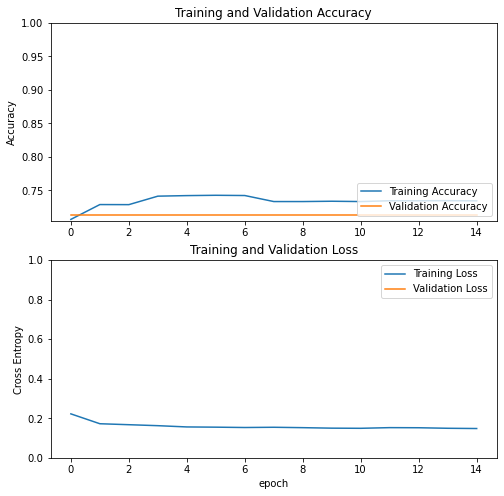

In [78]:
# to get the learning curves for train and test data
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

final evaluation, before fine tuning

In [79]:
y_pred = np.round ( model.predict ( test_images ) )

# to get the confusion matrix,
confusion_matrix1 = confusion_matrix ( one_hot_back_convert( test_labels ) ,\
                                     one_hot_back_convert( y_pred ) )
confusion_matrix1 = np.array (confusion_matrix1)

# to get classification report,
classification_report1 = classification_report ( test_labels , y_pred )

45/45 [==============================] - 79s 2s/step


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
# to print the confusion matrix,
print ( 'prediction' )
cm = pd.DataFrame ( index = [ f'actual = {i}' for i in range (5) ],\
             columns = [ f'{i}' for i in range (5) ] ,\
             data = confusion_matrix1 )

print ( cm )

# to print classification report,
print ( '-'*80 )
print ( 'classifiction report' )
print (classification_report1)
print ()

print ( 'classification accuracy,' )
print ( confusion_matrix1.trace() / confusion_matrix1.sum() )
print ()
print ( 'classification between DR and no-DR' )
print ( (confusion_matrix1 [0,0] + confusion_matrix1.sum()\
         - confusion_matrix1[1,:].sum() - confusion_matrix1[:,1].sum()) / (confusion_matrix1.sum()) )
print ()
print ( 'classification accuracy for differentiating between prolific and non prolific' )
print ( (confusion_matrix1.trace() - confusion_matrix1[0,0] )\
       / ( confusion_matrix1.sum() - confusion_matrix1[1,:].sum()\
       - confusion_matrix1[:,1].sum() + confusion_matrix1 [0,0] ) )
print ()
print ('classification accuracy for differentiating within non-prolific DR')
print ( (confusion_matrix1.trace() - confusion_matrix1[0,0] - confusion_matrix1 [-1,-1])\
      / ( confusion_matrix1.sum() + confusion_matrix1[0,0] + confusion_matrix1 [-1,-1]\
        - confusion_matrix1[1,:].sum() - confusion_matrix1[:,1].sum()\
        - confusion_matrix1[-1,:].sum() - confusion_matrix1[:,-1].sum()))

prediction
               0  1  2  3  4
actual = 0  1017  0  0  0  0
actual = 1   112  0  0  0  0
actual = 2   230  0  0  0  0
actual = 3    32  0  0  0  0
actual = 4    36  0  0  0  0
--------------------------------------------------------------------------------
classifiction report
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1017
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       230
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        36

   micro avg       0.71      0.71      0.71      1427
   macro avg       0.14      0.20      0.17      1427
weighted avg       0.51      0.71      0.59      1427
 samples avg       0.71      0.71      0.71      1427


classification accuracy,
0.7126839523475823

classification between DR and no-DR
1.634197617379117

classification accuracy for differentiating between prolific and non 

_____________________________________________________________________________________________________

Now, we try to fine tune the model

Note: It is much better to fine tune the model only after it has undergone transfer learning

In [81]:
# number of layers in the base model,
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards,
fine_tune_at = -7 # the number should be -ve

for layer in model.layers[fine_tune_at:]:
    layer.trainable = True

Number of layers in the base model:  176


In [82]:
# to compile the model,
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop (learning_rate = base_learning_rate/10),
              metrics=['accuracy'])

# to get summary of the model,
model.summary ()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0   

In [84]:
# for first case, history is kept as it is
train_images , train_labels = images_and_labels ( main_path = train_path , name = 'train1' )
# fine_tune_sub_epochs = 10
training_history = model.fit(train_images, train_labels,\
                    validation_data = ( test_images , test_labels ),\
                    epochs = initial_sub_epochs,\
                    batch_size = BATCH,\
                    class_weight = weights )
print (' -'*40)
print ( 'fine tuning for train 1 completed' )
print (' -'*40)

acc , val_acc , loss , val_loss = [] , [] , [] , []

acc += training_history.history['accuracy']
val_acc += training_history.history['val_accuracy']

loss += training_history.history['loss']
val_loss += training_history.history['val_loss']

for i in range ( 2,5 ):
    train_images , train_labels = images_and_labels ( main_path = train_path , name = f'train{i}' )
    training_history = model.fit(train_images, train_labels,\
                        validation_data = ( test_images , test_labels ),\
                        epochs = initial_sub_epochs*i,\
                        initial_epoch = training_history.epoch[-1],\
                        batch_size = BATCH,\
                        class_weight = weights )
    print (' -'*40)
    print ( f'fine tuning for train {i} completed' )
    print (' -'*40)
    
    acc += training_history.history['accuracy']
    val_acc += training_history.history['val_accuracy']
    
    loss += training_history.history['loss']
    val_loss += training_history.history['val_loss']

Epoch 1/3
263/263 [==============================] - 1291s 5s/step - loss: 0.1451 - accuracy: 0.7314 - val_loss: 1.3831 - val_accuracy: 0.7127
Epoch 2/3
263/263 [==============================] - 1257s 5s/step - loss: 0.1426 - accuracy: 0.7314 - val_loss: 1.2587 - val_accuracy: 0.7127
Epoch 3/3
263/263 [==============================] - 1144s 4s/step - loss: 0.1415 - accuracy: 0.7314 - val_loss: 1.2778 - val_accuracy: 0.7127
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
fine tuning for train 1 completed
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 3/6
263/263 [==============================] - 1139s 4s/step - loss: 0.1390 - accuracy: 0.7430 - val_loss: 1.2572 - val_accuracy: 0.7127
Epoch 4/6
263/263 [==============================] - 1141s 4s/step - loss: 0.1373 - accuracy: 0.7430 - val_loss: 1.2802 - val_accuracy: 0.7127
Epoch 5/6
263/263 [==============================] - 1124s 4s/step - loss: 0.1367 - accur

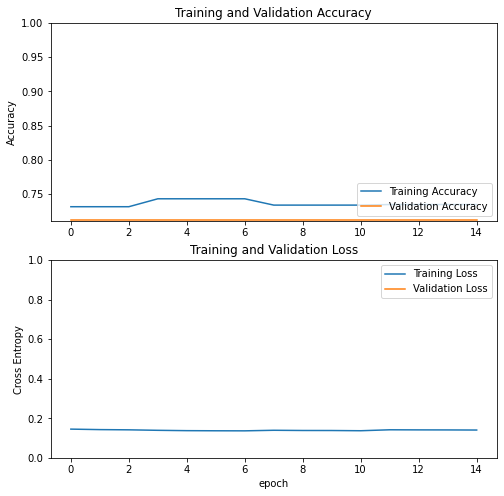

In [85]:
# to get the learning curves for train and test data
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

_____________________________________________________________________________________________________

Final Evaluation, after fine tuning

In [86]:
#loss, accuracy = model.evaluate(test_dataset)
#print('Test accuracy :', accuracy)

y_pred = np.round ( model.predict ( test_images ) )

# to get the confusion matrix,
confusion_matrix2 = confusion_matrix ( one_hot_back_convert( test_labels ) ,\
                                     one_hot_back_convert( y_pred ) )
confusion_matrix2 = np.array ( confusion_matrix2 )
# to get classification report,
classification_report2 = classification_report ( test_labels , y_pred )

45/45 [==============================] - 53s 1s/step


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
# to print the confusion matrix,
print ( 'prediction' )
cm = pd.DataFrame ( index = [ f'actual = {i}' for i in range (5) ],\
             columns = [ f'{i}' for i in range (5) ] ,\
             data = confusion_matrix2 )

print ( cm )

# to print classification report,
print ( '-'*80 )
print ( 'classifiction report' )
print (classification_report2)
print ()

print ( 'classification accuracy,' )
print ( confusion_matrix2.trace() / confusion_matrix2.sum() )
print ()
print ( 'classification between DR and no-DR' )
print ( (confusion_matrix2 [0,0] + confusion_matrix2.sum()\
         - confusion_matrix2[1,:].sum() - confusion_matrix2[:,1].sum()) / (confusion_matrix2.sum()) )
print ()
print ( 'classification accuracy for differentiating between prolific and non prolific' )
print ( (confusion_matrix2.trace() - confusion_matrix2[0,0] )\
       / ( confusion_matrix2.sum() - confusion_matrix2[1,:].sum()\
       - confusion_matrix2[:,1].sum() + confusion_matrix2 [0,0] ) )
print ()
print ('classification accuracy for differentiating within non-prolific DR')
print ( (confusion_matrix2.trace() - confusion_matrix2[0,0] - confusion_matrix2 [-1,-1])\
      / ( confusion_matrix2.sum() + confusion_matrix2[0,0] + confusion_matrix2 [-1,-1]\
        - confusion_matrix2[1,:].sum() - confusion_matrix2[:,1].sum()\
        - confusion_matrix2[-1,:].sum() - confusion_matrix2[:,-1].sum()))

prediction
               0  1  2  3  4
actual = 0  1017  0  0  0  0
actual = 1   112  0  0  0  0
actual = 2   230  0  0  0  0
actual = 3    32  0  0  0  0
actual = 4    36  0  0  0  0
--------------------------------------------------------------------------------
classifiction report
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1017
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       230
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        36

   micro avg       0.71      0.71      0.71      1427
   macro avg       0.14      0.20      0.17      1427
weighted avg       0.51      0.71      0.59      1427
 samples avg       0.71      0.71      0.71      1427


classification accuracy,
0.7126839523475823

classification between DR and no-DR
1.634197617379117

classification accuracy for differentiating between prolific and non 

for painted images

In [88]:
def label ( image_array ): # predicts the label, if given the image path
    c = np.round ( model.predict ( np.array ([image_array]) ) )
    c = c[0]
    
    for i in range (5):
        if c[i] == 1.0:
            return i

--------------------------------------------------------------------------------
for DR severity, 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
image name = 17_left
level = 0
new expected level = not 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
true image


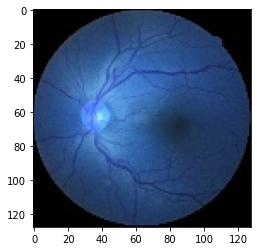

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
new image


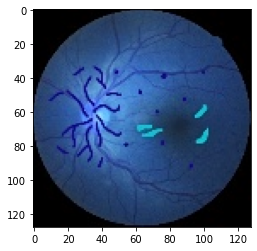

1/1 [==============================] - 0s 136ms/step
predicted level = 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
for DR severity, 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
image name = 125_left
level = 0
new expected level = not 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
true image


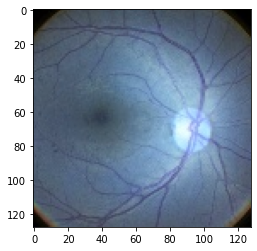

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
new image


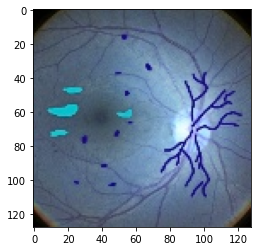

1/1 [==============================] - 0s 135ms/step
predicted level = 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
for DR severity, 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
image name = 140_left
level = 0
new expected level = not 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
true image


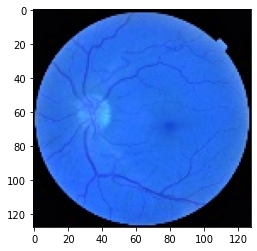

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
new image


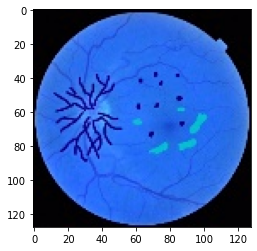

1/1 [==============================] - 0s 125ms/step
predicted level = 0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
--------------------------------------------------------------------------------


In [89]:
painted_images_path = 'D:\\courses\\ic 272 data science 3\\project 2022\\diabetic retinography\\new2\\paint images\\'

# now, to show (1) the images, (2) their modifications, (3) expected class, (4) predicted class
old = 'previous images\\'
new = 'new images\\'

labels = pd.read_csv ( painted_images_path + 'labels.csv' )

for i in range (1):
    for image in labels [ labels['level']==i ]['image'] :
        print ('-'*80)
        print ( f'for DR severity, {i}' )
        print ( ' -'*40 )
        
        print ( f'image name = {image}' )
        print ( f'level = {i}' )
        print ( 'new expected level = not 0' )
               
        print ( ' -'*40 )
        print ('true image')
        img_array = cv2.imread ( painted_images_path + old + image + '.jpeg' )
        plt.imshow ( img_array )
        plt.show ()
        
        print ( ' -'*40 )
        print ('new image')
        img_array = cv2.imread ( painted_images_path + new + image + '.jpg' )
        plt.imshow ( img_array )
        plt.show ()
        print ( f'predicted level = { label( img_array ) }' )
        
        print ( ' -'*40 )
        print ('-'*80)


_____________________________________________________________________________________________________